In [2]:
# 
# Import Packages
#
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

print('Packages imported.')

Packages imported.


In [ ]:
#
# Read/Display images functions
#
convert = lambda category : int(category == 'dog')

def read_images(path, use_convert):  
    X = []
    y = []
    for p in os.listdir(path):
        category = p.split(".")[0]
        if (use_convert):
            category = convert(category)
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)
    return (X, y)

def read_train_images(path):
    return read_images(path, True)

def read_test_images(path):
    return read_images(path, False)

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i], cmap="gray")
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [ ]:
print('Reading train image files...')
main_dir = "../input/dogs-vs-cats"
train_dir = "train/train"
path = os.path.join(main_dir,train_dir)
(X_train, y_train) = read_train_images(path)
print('Reading train image files done.')

In [ ]:
#
# Show some sample images
#            
random_images = []
for i in range(5):
    r = random.randint(1,len(X_train)-1)    
    random_images.append(X_train[r])    
grid_display(random_images, [], 5, (25, 25))

In [ ]:
#
# Make numpy arrays and normalize image data
#
X_train = np.array(X_train).reshape(-1, 80, 80, 1)
y_train = np.array(y_train)

X_train_normalized =  X_train / 255.0

print(f'X_train {X_train_normalized.shape}')
print(f'y_train {y_train.shape}')

In [ ]:
#
# Build Convolutional Neural Net 
#

model = Sequential()

input_shape = X_train_normalized.shape[1:]

# Adds a densely-connected layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add another densely-connected convolution layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add another densely-connected convolution layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add flatten layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Add output neruon with sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#
# Train Network 
#
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
# 
# Predict
#
main_dir = "../input/dogs-vs-cats"
test_dir = "test1/test1"
test_path = os.path.join(main_dir,test_dir)
print('reading Test images...')
(X_test, y_test) = read_test_images(test_path)

X_test = np.array(X_test).reshape(-1, 80, 80, 1)
y_test = np.array(y_test)
X_test_normalized =  X_test / 255.0
print('Reading test images done')

In [ ]:
#
# Show some sample predictions
#
random_images = []
random_titles = []
for i in range(10):
    r = random.randint(1, len(X_test)-1)    
    random_images.append(X_test[r].reshape(80, 80))    
    pred =  model.predict(X_test_normalized[r].reshape(1, 80, 80, 1))
    if pred >= 0.5:        
        random_titles.append('Dog')
    else:        
        random_titles.append('Cat')
        
grid_display(random_images, random_titles, 5, (25, 25))


In [ ]:
#
# Submission
#

predictions = model.predict(X_test_normalized)
predicted_val = [int(round(p[0])) for p in predictions]
submission_df = pd.DataFrame({'id':y_test, 'label':predicted_val})

# write data frame wot csv
submission_df.to_csv("submission.csv", index=False)

In [ ]:
#
# Save and Load model
#
from keras.models import load_model

model_json = model.to_json()
with open("cat_dog_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("cat_dog_model.h5")

In [4]:
#
# Evaluate model with an image from internet
#
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

print(os.listdir("../input"))

with open('../input/cats-or-dogs/cat_dog_model.json', 'r') as f:
    loaded_model = model_from_json(f.read(), custom_objects={'GlorotUniform': glorot_uniform() })   
loaded_model.load_weights('../input/cats-or-dogs/cat_dog_model.h5')
    
print('model loaded')
loaded_model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

['dogs-vs-cats', 'cats-or-dogs']
Instructions for updating:
Colocations handled automatically by placer.
model loaded


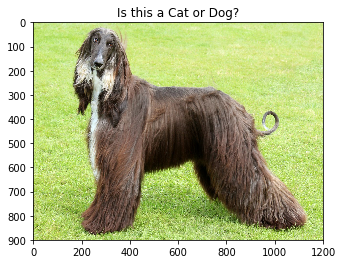

(80, 80)
DOG 99.93271827697754%


In [5]:
import cv2
from PIL import Image
import requests
from io import BytesIO

url='https://www.sciencealert.com/images/SmartDogs5.jpg'
#url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/13002253/GettyImages-521536928-_1_.jpg'
#url = 'https://www.humanesociety.org/sites/default/files/styles/400x400/public/2018/06/cat-217679.jpg?h=c4ed616d&itok=H0FcH69a'
#url='https://upload.wikimedia.org/wikipedia/commons/9/96/Himalayan_CAT.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.title('Is this a Cat or Dog?')
plt.show()


open_cv_image = np.array(img) 
open_cv_gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
open_cv_gray_image = cv2.resize(open_cv_gray_image, dsize=(80, 80)) 
open_cv_gray_image_scaled = open_cv_gray_image / 255.0


print (open_cv_gray_image_scaled.shape)
pred = loaded_model.predict(open_cv_gray_image_scaled.reshape(1, 80, 80, 1))[0][0]
if (pred > 0.5):
    print(f'DOG {pred * 100}%')
else:
    print(f'CAT {(1-pred)*100}%')